## Tutorial Flower - Federated Learning

O tutorial feito abaixo está disponível em: https://colab.research.google.com/github/adap/flower/blob/main/examples/flower-in-30-minutes/tutorial.ipynb#scrollTo=gLucT6KFnIT7

> ler: https://arxiv.org/abs/2302.00487
> https://arxiv.org/abs/2312.16475

In [3]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
# importação das bibliotecas necessárias
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset

def get_mnist_dataloaders(mnist_dataset, batch_size : int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # preparo as funções de transformação
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # construo os dataloaders do pytorch
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle = True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader

# faz o download do conjuento de dados
mnist = load_dataset("ylecun/mnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
# visão rápida do conjunto de dados
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

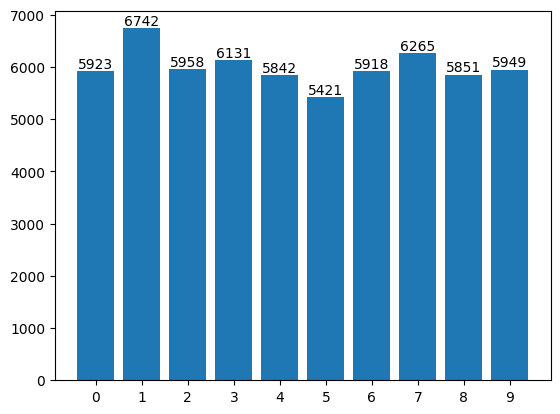

In [6]:
# visualizo a distribuição dos dados de treino por meio de um histograma
import matplotlib.pyplot as plt
from collections import Counter

# construo o histograma
all_labels = mnist["train"]["label"]
all_labels_counts = Counter(all_labels)

# visualizo o histograma
bar = plt.bar(all_labels_counts.keys(), all_labels_counts.values())
_ = plt.bar_label(bar)

# plot formatting ?
_ = plt.xticks([label for label in all_labels_counts.keys()])


will display images with idx: [37027, 2570, 11615, 47748, 6062, 41697, 53718, 55773, 21417, 27200, 33770, 45954, 1654, 31907, 2019, 56908, 15679, 11695, 44249, 54360, 59714, 46360, 23508, 16024, 1301, 13372, 27748, 4626, 27650, 32724, 25720, 13888]


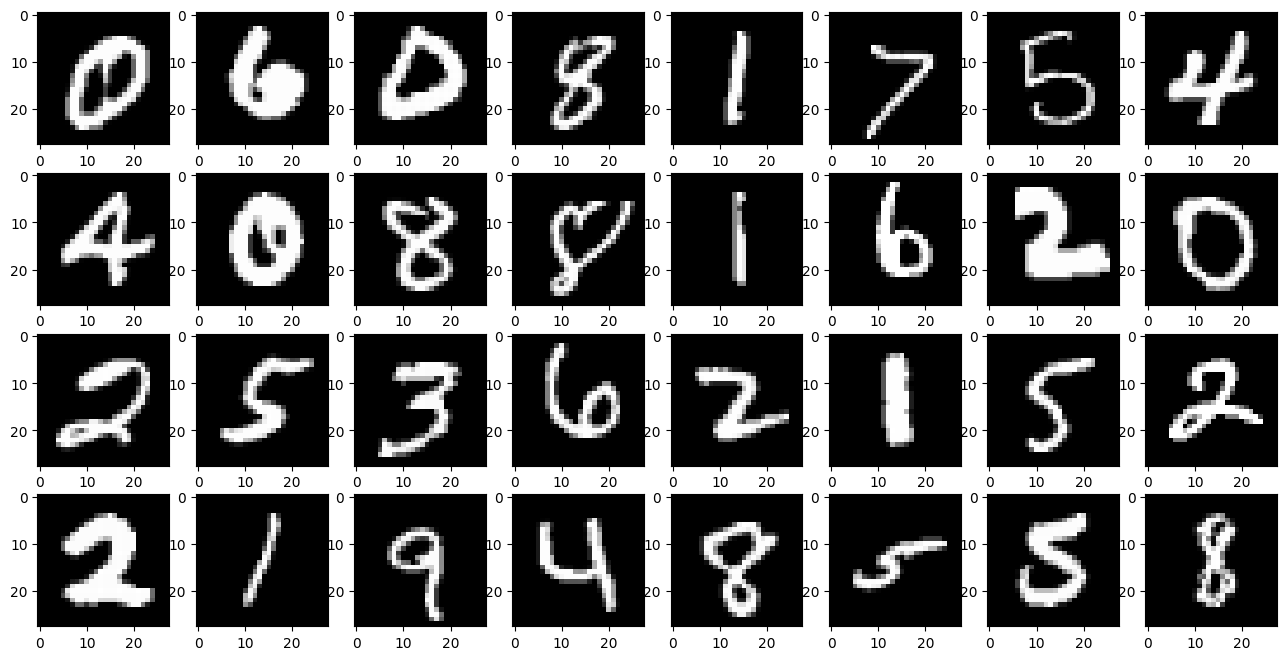

In [7]:
# visualizo 32 imagens do conjunto de dados
import random
import numpy as np
from PIL import Image
import io

def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
  trainset_data = [Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]] # consigo as imagens
  idx = list(range(len(trainset_data))) # crio uma lista de índices em order crescente com base no tamanho do meu conjunto de dados de treino
  random.shuffle(idx) # embaralho os índices da lista
  idx = idx[:n] # pego os primeiros n índices da lista embaralhada
  if verbose:
    print(f"will display images with idx: {idx}")

  # construo o quadro que será utilizado para imprimir as imagens
  num_cols = 8
  num_rows = int(np.ceil(len(idx) / num_cols))
  fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

  # exibo as imagens no quadro
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

visualise_n_random_examples(mnist["train"], n=32)

*Uma arquitetura CNN*

Uma arquitetura CNN típica é usada para ilustrar a diferença entre a maneira tradicinal e a federada de se fazer aprendizado de máquina.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# modelo da rede neural convolucional a ser usado como base para a comparação
class Net(nn.Module):
  def __init__(self, num_classes: int) -> None:
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear( 16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [9]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


*O loop de treino*

In [ ]:
# defino as funções de treino, teste e a que irá rodar o modelo

def train (net, trainloader, optimizer, device="cpu")
  """Treino o modelo nos dados de treino"""
  criterion = torch.nn.CrossEntropyLoss() # loss function -> calcula a diferença entre a predição do modelo com o resultado dos dados reais
  net.to(device) # envio o modelo para o dispositivo desejado
  net.train() # coloco o modelo em modo de treino
  for batch in trainloader:
    images, labels = batch["image"].to(device), batch["label"].to(device)
    optimizer.zero_grad()
    loss = criterion(net(images), labels)
    loss.backward()
    optimizer.step()

def test(net, testloader, device):
  """Validação da rede neutral com base no conjunto de dados de teste"""
  criterion = torch.nn.CrossEntropyLoss()
  correct, loss = 0, 0
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch in testloader:
      images, labels = batch["image"].to(device), batch["label"].to(device)
      outputs = net(images)
      loss += criterion(outputs, labels).item()
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
  acuracy = correct / len(testloader.dataset)
  return loss, accuracy
